# Conversion Rate
@ 20200528 Chunlei Zhou
## Project Introduction
### Goal
1. Predict conversion rate;
2. Come up with recommendations for the product team and the marketing team to improve conversion rate.

### Data
The data set 'conversion_data.csv' has information about signed-in users during one session. Each row is a user session.

    Columns:
        country: user country based on the IP address;
        age: user age. Self-reported at sign-in step;
        new_user: whether the user created the account during this session (1) or had already an account and simply came back to the site (0);
        source: marketing channel source:
            Ads: came to the site by clicking on an advertisement
            Seo: came to the site by clicking on search results
            Direct: came to the site by directly typing the URL on the browser
        total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session
        converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything, in other words, not converted. The company goal is to increase converstion rate: #conversions/total sessions
### Initial Plan
Use supervise learning to build a model and recognize users that are likely to be converted.
Use the model to cluster user sessions to converted and not converted. 
Count converted sessions and divided by total number of sessions.

## Data Preprocessing

In [1]:
# load data
import pandas as pd
df = pd.read_csv('conversion_rate.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [2]:
# get data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


Number of Total sample: 316200;
Number of Features: 5;
Target (y): converted (with 1 represents converted, 0 represents not converted);

In [3]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:
# remove outlier

'''
From the describe above, we noticed the max age is 123. 
Typically, records of human lifespan above age 100 are highly susceptible to errors.
Thus, records with age above 100 are considered as outlier and should be removed.
'''

df = df[df['age'] < 100]

In [5]:
'''
There are two classes 1: converted; 0: not converted.
How many samples are there in each class?
'''
df.converted.value_counts()

0    306000
1     10198
Name: converted, dtype: int64

## Exploratory Analysis

### Helper Functions

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation Analysis using Heatmap
def correlation_heatmap(dataset, width = None, length = None):
    
    '''
    This function will plot a heatmap for the input dataset to show correlation between different x_features and y
    Input:  
            df: a dataset with x_features and y(last column)
            width, length: parameters that defined figure size
    Output: a correlation heatmap
    '''
    
    if width and length:
        # define figure size based on the input value of width and length
        fig,ax = plt.subplots(figsize = (width, length))
    
    else:
        # default figure size when width and length are none.
        fig,ax = plt.subplots()
    
    # Plot the heatmap
    ax = sns.heatmap(dataset.corr(),vmin = -1, vmax = 1, square = True, cmap = sns.diverging_palette(240, 10, as_cmap=True))
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    return ax


# Explore relationship between conversion and each feature using bar plots.
def groupcheck(df, feature: str, nrow =  None, ncol = None, width = None, length = None, font = None):
    
    '''
    This function will output a bar plot for the input dataset to show the relationship between conversion and a certain feature.
    Inputs: 
            df: a dataset with x features and y (target)
            feature: the feature that is used to plot against target
            nrow, ncol: parameters defined the composing of plots
            width, length: parameters defined figure size
            font: defined the font size of legend
    Outputs:
            Left plot: Dstribution of converstion for each value of the feature
            Right plot: Converstion rate calculated for each value of the feature
    '''
    
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(width, length))
    
    # Plot the left bar chart
    sns.countplot(x = feature, hue = 'converted', data = df, ax = ax[0])
    ax[0].set_title('Count Plot of ' + feature, fontsize = font)
    ax[0].set_yscale('log')
    ax[0].set_xlabel(feature)
    ax[0].set_ylabel('convertion count')
    
    # Plot the right bar chart
    sns.barplot(x=feature, y='converted', data=df, ax=ax[1]);
    ax[1].set_title('Conversion Rate per '+feature, fontsize = font)
    ax[1].set_xlabel(feature)
    ax[1].set_ylabel('convertion rate')
    
    # Display plots
    plt.tight_layout()
    plt.show()
    
# It seems that using histogram is more suitable for 'age' and 'total_pages_visited'.
def grouphist(df, feature: str, hist_kws: dict, nrow =  None, ncol = None, width = None, length = None, font = None):
    
    '''
    This function will output a histogram for the input dataset to show the relationship between conversion and a certain feature.
    Use this function, instead of the previous one, when there are too much values for a feature.
    Inputs: 
            df: a dataset with x features and y (target)
            feature: the feature that is used to plot against target
            hist_kws: includes parameters that defined how plots are displayed
            nrow, ncol: parameters defined the composing of plots
            width, length: parameters defined figure size
    Outputs:
            Left plot: Dstribution of converstion for each value of the feature
            Right plot: Converstion rate calculated for each value of the feature
    '''
    
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(width, length))
    
    # Group the conversion by feature values
    grouped = df[[feature, 'converted']].groupby(feature).mean().reset_index()
    
    # Plot the left histogram
    sns.distplot(df[df['converted'] == 0][feature], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
    ax[0].set_title('Count Plot of '+feature, fontsize=font)
    ax[0].set_xlabel(feature)
    ax[0].set_ylabel('convertion count')
    ax[0].legend()
    
    # Plot the right histogram
    sns.distplot(df[df['converted'] == 1][feature], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws) 
    ax[1].plot(grouped[feature], grouped['converted'], '.-')
    ax[1].set_title('Conversion Rate vs. '+feature, fontsize=font)
    ax[1].set_xlabel(feature)
    ax[1].set_ylabel('convertion rate')
    ax[1].grid(True)
    
    # Display plots
    plt.show()

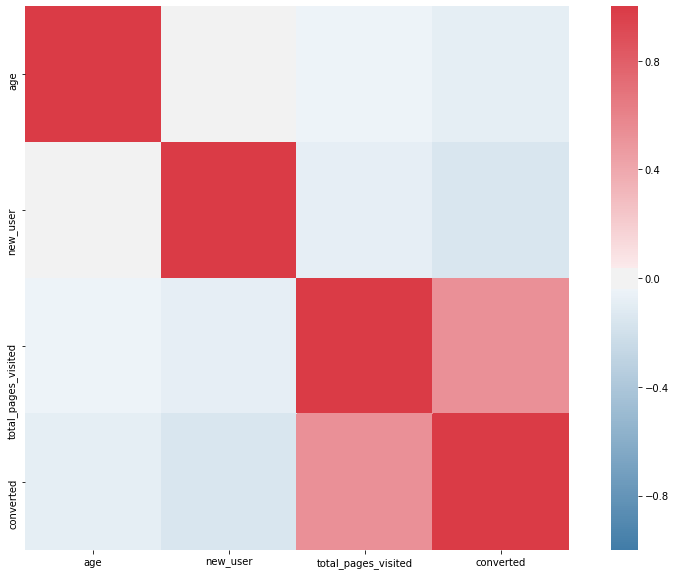

In [7]:
# Plot correlation heatmap for dataset conversion_rate.csv
correlation_heatmap(df, width = 15, length = 10)

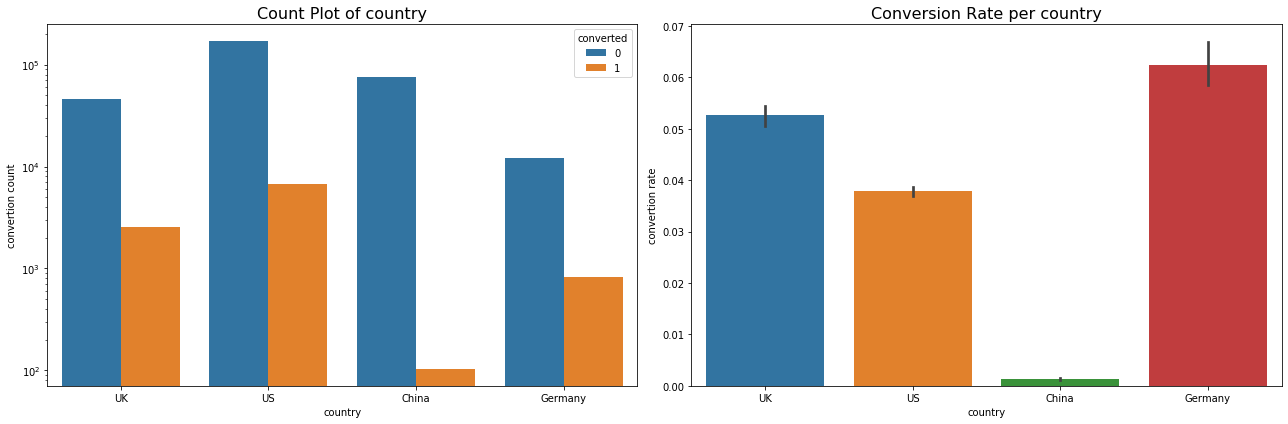

In [8]:
# Main purpose is to explore the relationship between features and conversion.

# 1. The relationship between country and converted
groupcheck(df, 'country', 1, 2, 18, 6, 16)

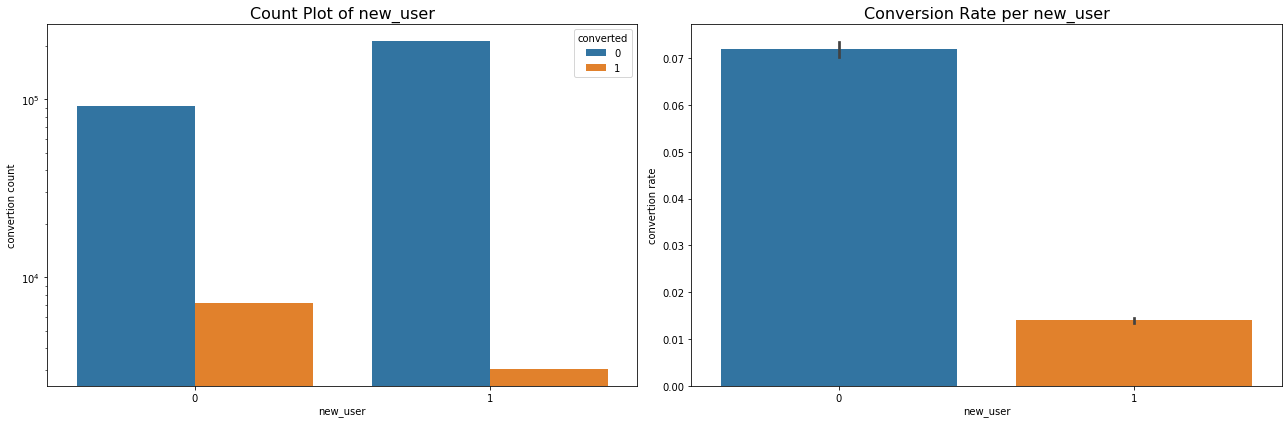

In [9]:
# 2. The relationship between new_user and converted
groupcheck(df, 'new_user', 1, 2, 18, 6, 16)

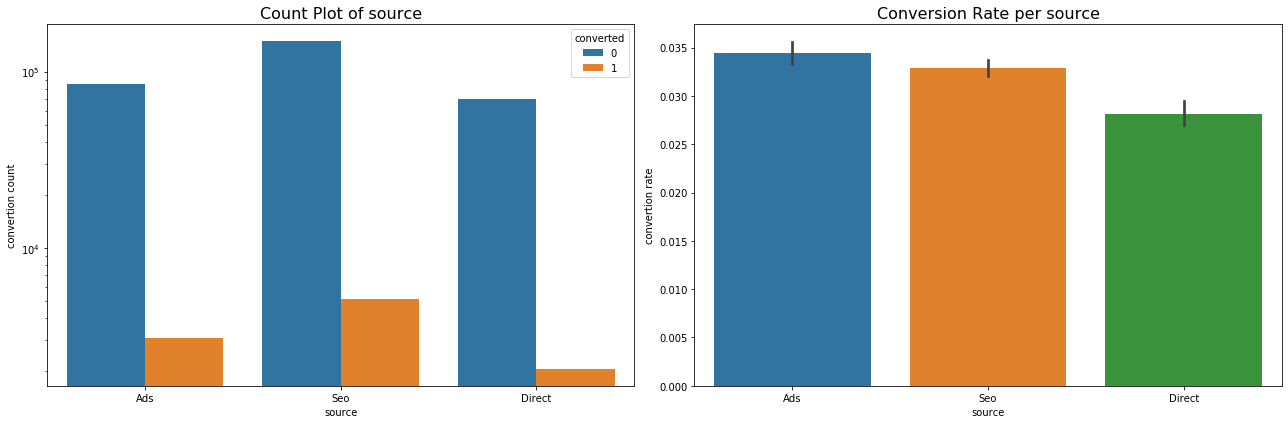

In [10]:
# 3. The relationship between new_user and converted
groupcheck(df, 'source', 1, 2, 18, 6, 16)

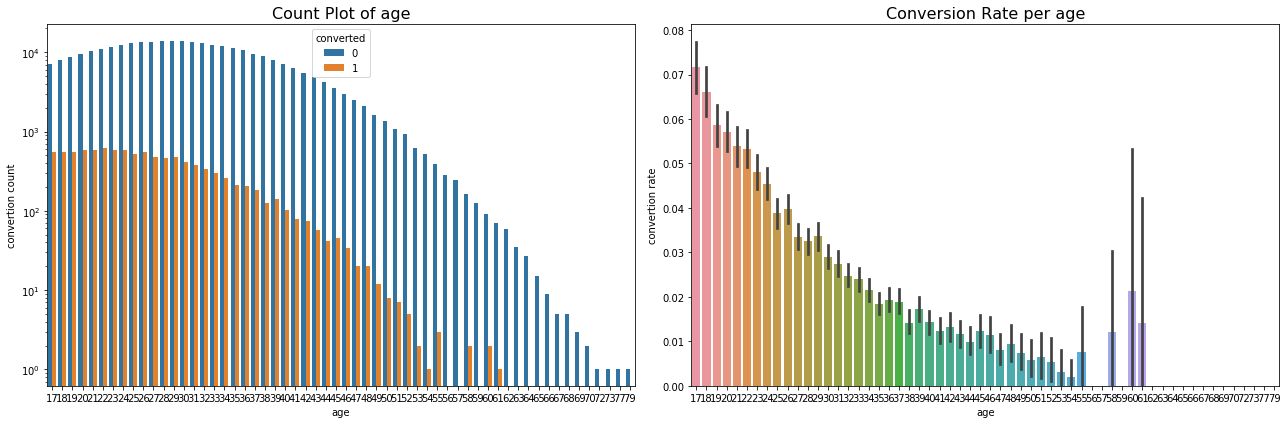

In [11]:
# 4. The relationship between age and converted
groupcheck(df, 'age', 1, 2, 18, 6, 16)

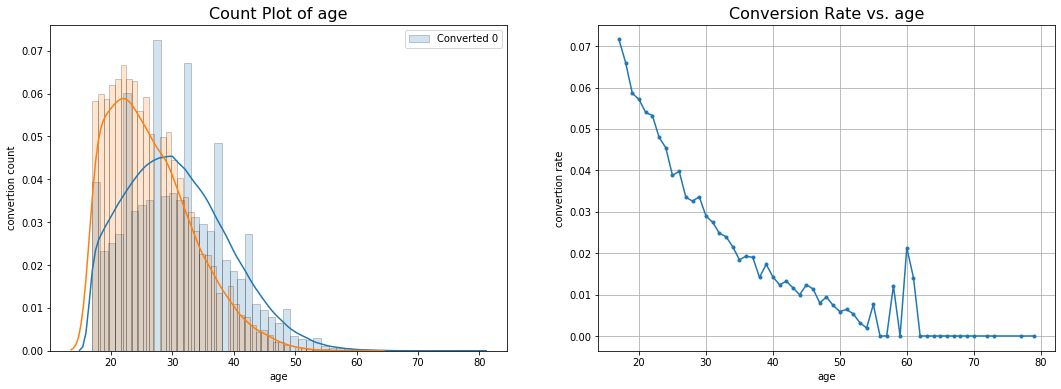

In [12]:
# Histogram for feature 'age'
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
grouphist(df, 'age', hist_kws, 1, 2, 18, 6, 16)

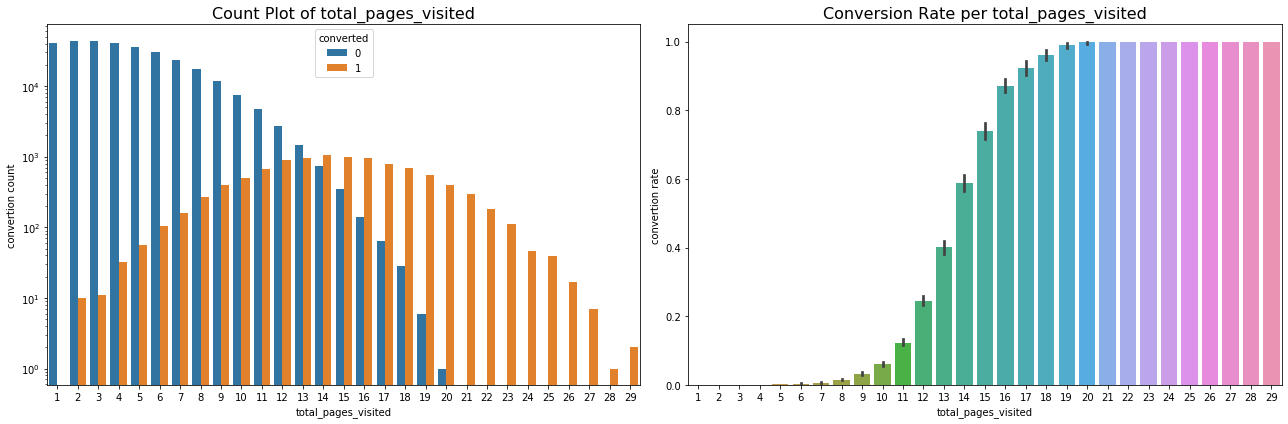

In [13]:
# 5. The relationship between total pages visited and converted
groupcheck(df, 'total_pages_visited', 1, 2, 18, 6, 16)

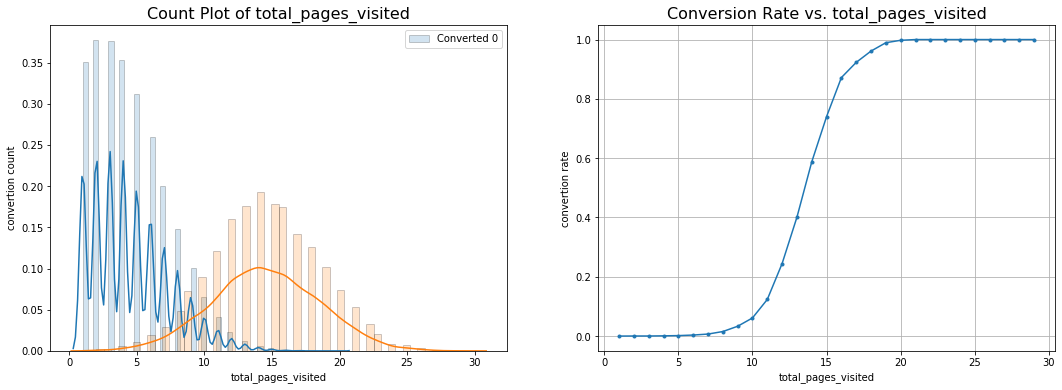

In [14]:
# Histogram for feature 'total_pages_visited'
grouphist(df, 'total_pages_visited', hist_kws, 1, 2, 18, 6, 16)

## Models

### Preperation Before Modeling
#### Convert catigorical features to numbers

In [15]:
'''
It is a binary classification, we can use logistic regression, SVM, Random Forest, and etc.
We will use training set to train all these models, use dev set to select the best model, 
and use the selected model to predict the conversion rate on test set.

To build a valid classification model, we need to convert the categorical variable to number.
Since it makes no sense to give any categorical value higher weight than other values, we cannot use label encoder.
One-hot encoder is a better choice.
'''

# One-Hot encoding for categorical data: 'source' and 'country'
source_enc = pd.get_dummies(df.source, prefix='source')
country_enc = pd.get_dummies(df.country, prefix='country')
df = pd.concat([df, country_enc, source_enc], axis=1)
df = df.drop(columns=['country','source'])

# Train-Test Split based on 7:2:1 rule
print('How large is 70% of the whole dataset?', round(df.shape[0]*0.7))

# Randomly choose 70% of total sample and save as train, 20% saved as dev, and 20% saved as test.
train = df.sample(frac =.7) # training set used to train models
dev = df.sample(frac =.2) # dev set used to select model
test = df.sample(frac =.1) # test set used to predict final results

# Extract X and y from datasets
train_y = train[['converted']]
train_x = train.drop(columns=['converted'])
dev_y = dev[['converted']]
dev_x = dev.drop(columns=['converted'])
test_y = test[['converted']]
test_x = test.drop(columns=['converted'])

How large is 70% of the whole dataset? 221339


### Model 1: Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
# Train a logistic regression model
LR = LogisticRegression(multi_class = 'ovr')
LR_fitted = LR.fit(train_x,train_y)
# Prediction using logistic regression model
LR_prediction = LR_fitted.predict(dev_x)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model 2: SVM

In [17]:
from sklearn import svm
SVM = svm.LinearSVC()
SVM_fitted = SVM.fit(train_x, train_y)
SVM_prediction = SVM_fitted.predict(dev_x)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Model 3: Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF_fitted = RF.fit(train_x, train_y)
RF_prediction = RF_fitted.predict(dev_x)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


### Model Selection

In [19]:
from sklearn.metrics import accuracy_score
print('''
Accuracy: 
- Logistic Regression: {:.2f}%
- SVM: {:.2f}%
- Random Forest: {:.2f}%
'''.format(100*accuracy_score(dev_y, LR_prediction), 
           100*accuracy_score(dev_y, SVM_prediction), 
           100*accuracy_score(dev_y, RF_prediction)))


Accuracy: 
- Logistic Regression: 98.62%
- SVM: 98.47%
- Random Forest: 98.71%



According to the performance of each model, the model we selected is Random Forest.

## Make Prediction

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np

In [21]:
# Plot the Confusion Matrix

def plot_confusion_matrix_improved(y_pred, y_true, width=None, length=None, title=None, normalize = False, cmap = None):
    
    '''
    This function visualizes the confusion matrix.
    Input: 
        y_pred: prediction of y;
        y_ture: truth
        width, length: figure size
        title: figure title
        normalize: normalize confusion matrix if normalize = True
        cmap: plot the given color map (map continue values to colors)
    Output: the visualized confusion matrix
    '''
    
    if width and length:
        # Define figure size based on the input values
        fig, ax = plt.subplots(figsize = (width, length),constrained_layout=True)
    
    else:
        # Default figure size
        fig, ax = plt.subplots(constrained_layout=True)
    
    # Default title
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix (Not Normalized)'
    
    # Default color (Red)
    if not cmap:
        cmap = plt.cm.Reds
    
    # Compute Confusion Matrix
    cm = confusion_matrix(y_true,y_pred)
    
    # Class Labels
    labels = unique_labels(y_pred, y_true)
    
    # Normalization
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)
        fmt = '.2f'
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix without Normalization')
        fmt = 'd'
    im = ax.matshow(cm, cmap = cmap)
    ax.figure.colorbar(im)
    
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='Actual', xlabel='Prediction')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.xaxis.tick_bottom()
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=45)
    ax.grid(False)
    ax.title.set_fontsize(16)
    ax.xaxis.label.set_fontsize(14) 
    ax.yaxis.label.set_fontsize(14)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    
    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    return ax

In [22]:
# Make prediction using test set report the accuracy

prediction = RF_fitted.predict(test_x)
print('''
Prediction Accuracy: 
- Random Forest: {:.2f}%
'''.format(100*accuracy_score(test_y, prediction)))


Prediction Accuracy: 
- Random Forest: 98.73%



In [23]:
# Report the model performance

print(classification_report(test_y, prediction, 
                            target_names = ['Not Converted','Converted']))

               precision    recall  f1-score   support

Not Converted       0.99      1.00      0.99     30605
    Converted       0.87      0.71      0.78      1015

     accuracy                           0.99     31620
    macro avg       0.93      0.86      0.89     31620
 weighted avg       0.99      0.99      0.99     31620



In [24]:
# Calculate the confusion matrix
y = test_y['converted'].to_numpy()
y_actu = pd.Series(y, name='Actual')
y_pred = pd.Series(prediction, name='Predicted')

# Confusion matrix without normalization
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'])#, margins=True)

# Nomalize the confusion matrix
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

In [25]:
# Original confusion matrix
df_confusion

Predicted,0,1
Actual,,
0,30493,112
1,290,725


In [26]:
# Normalized confusion matrix
df_conf_norm

Predicted,0,1
Actual,,
0,0.996340,0.110345
1,0.009476,0.714286


Confusion Matrix without Normalization


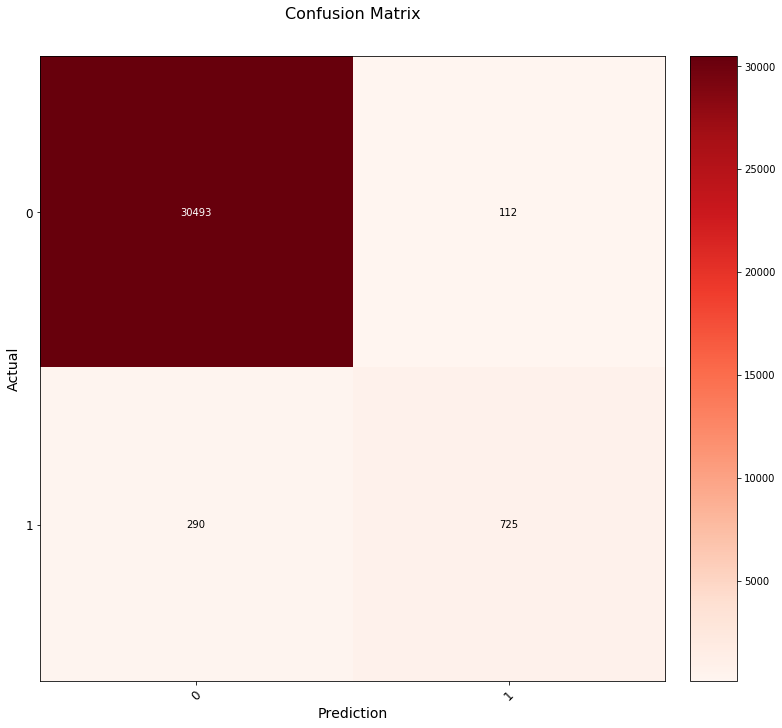

In [27]:
# Plot the confusion matrix (heatmap)
plot_confusion_matrix_improved(prediction, y, width=15, length=10,
                               title='Confusion Matrix')

In [28]:
# Analyze feature importance for each feature
from sklearn.metrics import auc, roc_curve

feats = {} # a dict to hold feature_name: feature_importance

for feature, importance in zip(test_x.columns, RF_fitted.feature_importances_):
    feats[feature] = importance #add the name/value pair 

# Construct a data frame using the feats dictionary
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini_importance'})

# Rank features based on importance of each feature
rank = importances.sort_values(by='Gini_importance')[::-1]

# Print the feature ranking
print("Feature ranking:")
print(rank)

Feature ranking:
                     Gini_importance
total_pages_visited         0.803801
age                         0.114779
new_user                    0.040491
country_China               0.024038
source_Ads                  0.003204
country_UK                  0.003062
source_Seo                  0.003060
source_Direct               0.002913
country_US                  0.002520
country_Germany             0.002131


Text(0.5, 0, 'Importance')

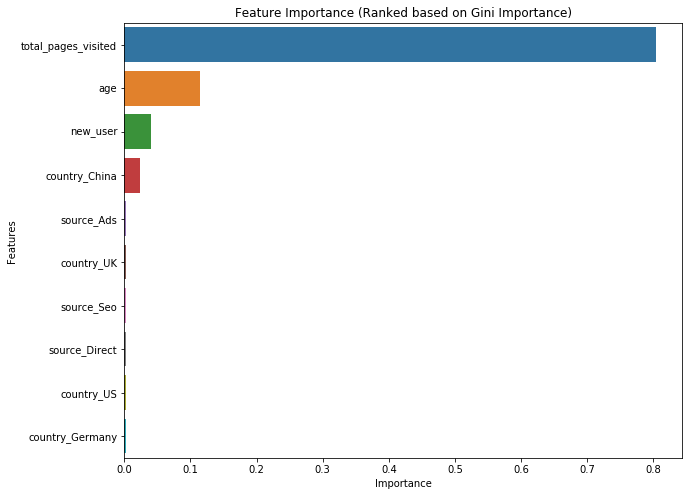

In [29]:
# Visualize the ranking of features based on importances
fig, ax = plt.subplots(figsize=(10, 8))
rank.reset_index(drop=False, inplace=True )
names = test_x.columns.tolist()
rank.reindex(names, axis=1)
sns.barplot(x = 'Gini_importance', y = 'index', data = rank)
ax.set_title('Feature Importance (Ranked based on Gini Importance)')
ax.set_ylabel('Features')
ax.set_xlabel('Importance')

In [31]:
# Check whether there is overfitting or not by comparing the model performance on train, dev, and test.

# Make prediction using training set
train_pred = RF_fitted.predict(train_x)

# Calculate the area under ROC curve for three sets respectively
train_fpr, train_tpr, _ = roc_curve(train_y, train_pred)
dev_fpr, dev_tpr, _ = roc_curve(dev_y, RF_prediction)
test_fpr, test_tpr, _ = roc_curve(test_y, prediction)

train_auc = np.round(auc(train_fpr, train_tpr), 3)
dev_auc = np.round(auc(dev_fpr, dev_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

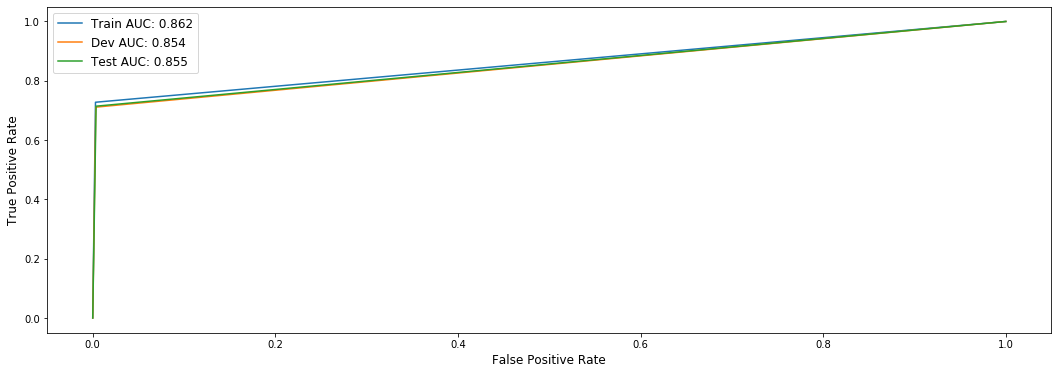

In [32]:
# Plot the ROC curve for three sets respectively
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(dev_fpr, dev_tpr, label='Dev AUC: ' + str(dev_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [33]:
# Calculate the conversion rate using the test set
conversion_rate = sum(prediction)/len(test)
actual_rate = sum(test_y['converted'])/len(test)
print('''
Conversion Rate (Test Set): 
- Predicted: {:.2f}%
- Actual: {:.2f}%
'''.format(100*conversion_rate,
          (100*actual_rate)))


Conversion Rate (Test Set): 
- Predicted: 2.65%
- Actual: 3.21%



In [34]:
# Calculate the conversion rate using the dev set
conversion_rate = sum(RF_prediction)/len(dev)
actual_rate = sum(dev_y['converted'])/len(dev)
print('''
Conversion Rate (Dev Set): 
- Predicted: {:.2f}%
- Actual: {:.2f}%
'''.format(100*conversion_rate,
          100*actual_rate))


Conversion Rate (Dev Set): 
- Predicted: 2.71%
- Actual: 3.35%



In [35]:
# Calculate the conversion rate using the training set
conversion_rate = sum(train_pred)/len(train)
actual_rate = sum(train_y['converted'])/len(train)
print('''
Conversion Rate (Train Set): 
- Predicted: {:.2f}%
- Actual: {:.2f}%
'''.format(100*conversion_rate,
          100*actual_rate))


Conversion Rate (Train Set): 
- Predicted: 2.62%
- Actual: 3.20%



In [36]:
# Calculate the conversion rate using the whole set
conversion_rate = (sum(train_pred) + sum(RF_prediction) + sum(prediction))/len(df)
actual_rate = sum(df['converted'])/len(df)
print('''
Conversion Rate (Total): 
- Predicted: {:.2f}%
- Actual: {:.2f}%
'''.format(100*conversion_rate,
          100*actual_rate))


Conversion Rate (Total): 
- Predicted: 2.64%
- Actual: 3.23%

